In [102]:
using PyPlot, Printf

include("decode.jl")
include("utils.jl")
include("regression.jl")
include("inference.jl")

include("UpdateRule.jl")
include("Leaky.jl")
include("VarSMiLe.jl")
include("ParticleFiltering.jl")
;

In [2]:
function plot_sbf(sbf, params, start, stop)
    x = collect(start:stop)
    y = sbf[start:stop]
    
    plot(x, y, label=params["label"])
    xlabel("t")
    ylabel(L"S_{BF}")
    title(@sprintf("Update rule: %s", params["rule"]))
    grid("on")
    legend()
end
;

In [3]:
function plot_theta(theta, params, start, stop)
    x = collect(start:stop)
    y = theta[start:stop]
    
    plot(x, y, label=params["label"])
    xlabel("t")
    ylabel(L"\theta")
    title(params["rule"])
    grid("on")
    legend()
end
;

In [93]:
function plot_posterior(posterior, params, start, stop)
    x = collect(start:stop)
    p = unwrap(posterior[start:stop])
    
    for i in 1:size(p,2)
        plot(x, p[:,i], label="m = $(i-1)") 
    end
    
    # plot(x, sum(p, dims=2), label="sum")
    
    xlabel("t")
    ylabel("Posterior")
    title(@sprintf("Update rule: %s", params["rule"]))
    grid("on")
    legend()
end
;

## Surprise

In [5]:
# generate sequence { 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 ... }
len = 400
seq = Array{Int32,1}(undef, len)

for i = 1:len÷2
    seq[i] = i % 3 == 0
end

for i = len÷2:len
    seq[i] = i % 4 == 0
end
;

### Fixed prior

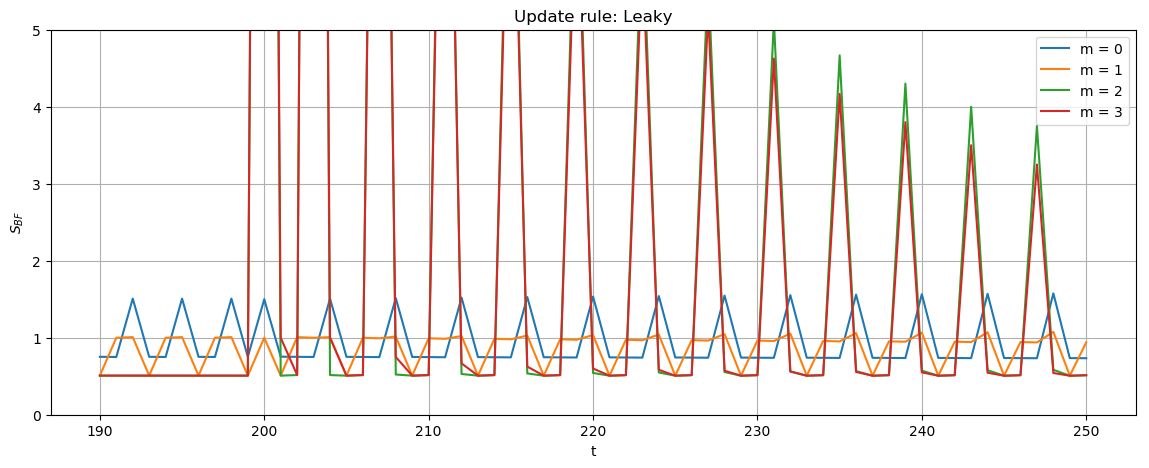

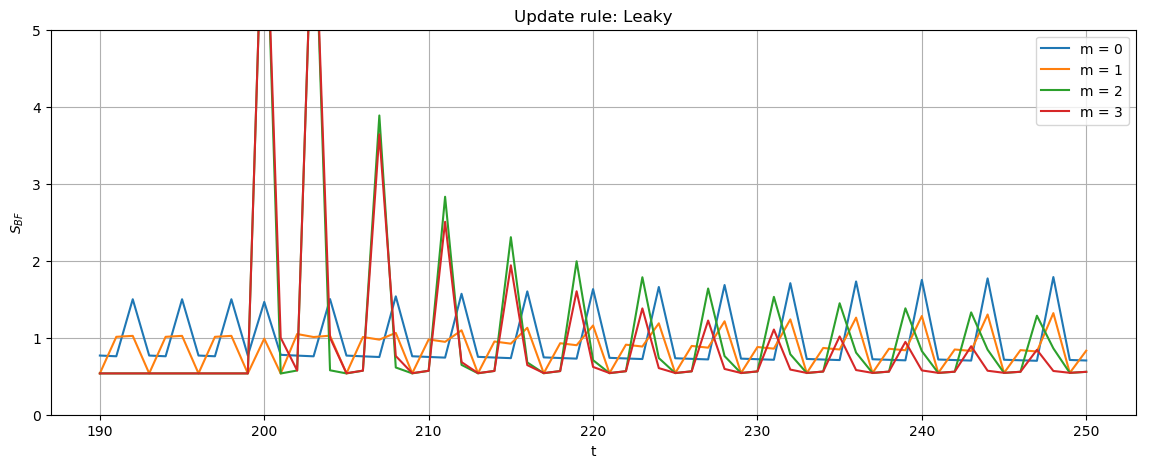

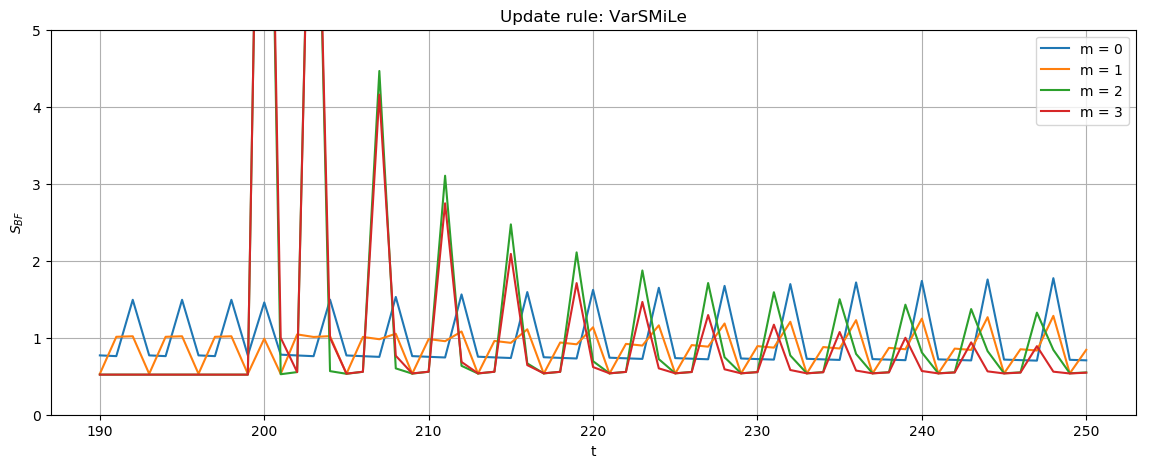

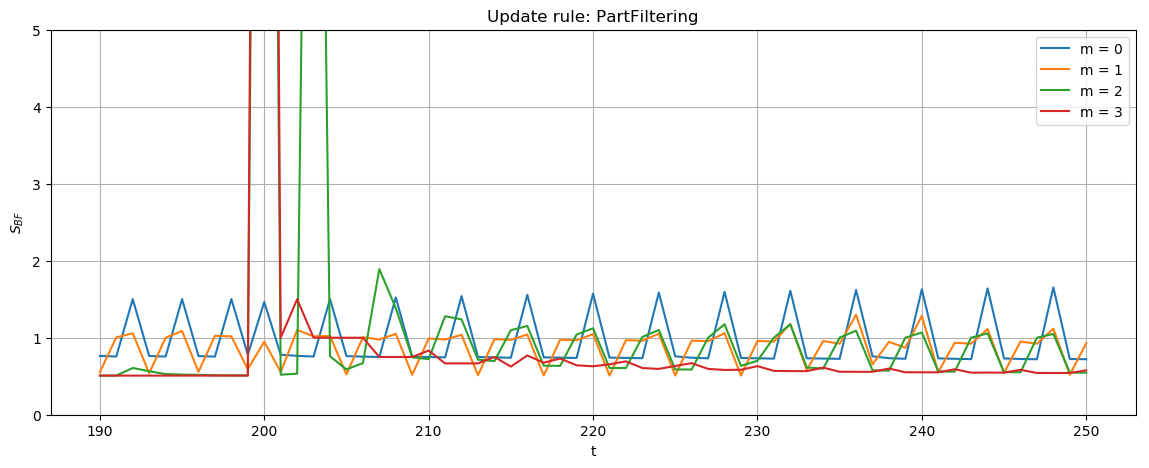

In [41]:
# rules to plot
rules = [
    m -> Leaky(Inf, prior_fixed(m), updateallcols = true),
    m -> Leaky(40, prior_fixed(m), updateallcols = true),
    m -> VarSMiLe(0.025, prior_fixed(m), updateallcols = true),
    m -> ParticleFiltering(0.025, 10, 2, prior_fixed(m), updateallcols = true)
]
m_values = [0, 1, 2, 3]

for rule in rules
    # reset figure
    fig, ax = subplots(figsize=(14,5))
    for m in m_values
        
        r = rule(m)
        sbf, theta = decodesbftheta(seq, r)
        
        # plotting params
        params = Dict("label" => "m = $m", "rule" => split(r.str, "(")[1])
        plot_sbf(sbf, params, 190, 250)
        
        # add y lim
        ax = gca()    
        ax.set_ylim([0,5])
    end
end
;

### Uniform prior, $m_{max} = 3$

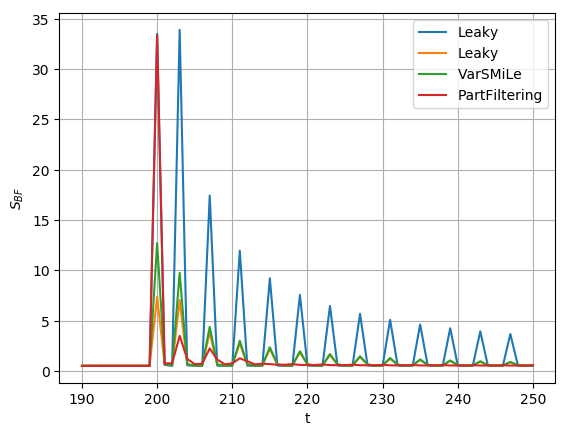

In [54]:
# rules to plot
prior = prior_uniform(3)

rules = [
    Leaky(Inf, prior, updateallcols=true),
    Leaky(40, prior, leakprior=true, updateallcols=true),
    VarSMiLe(0.025, prior, updateallcols=true),
    ParticleFiltering(0.025, 10, 3, prior, updateallcols=true)
]


for rule in rules
    sbf, theta = decodesbftheta(seq, rule)

    # plotting params
    params = Dict("label" => split(rule.str, "(")[1], "rule" => split(rule.str, "(")[1])
    plot_sbf(sbf, params, 190, 250)

    # add y lim
    ax = gca()    
    #ax.set_ylim([0,5])
end

PyPlot.title("")
;

## Posterior

### Uniform prior

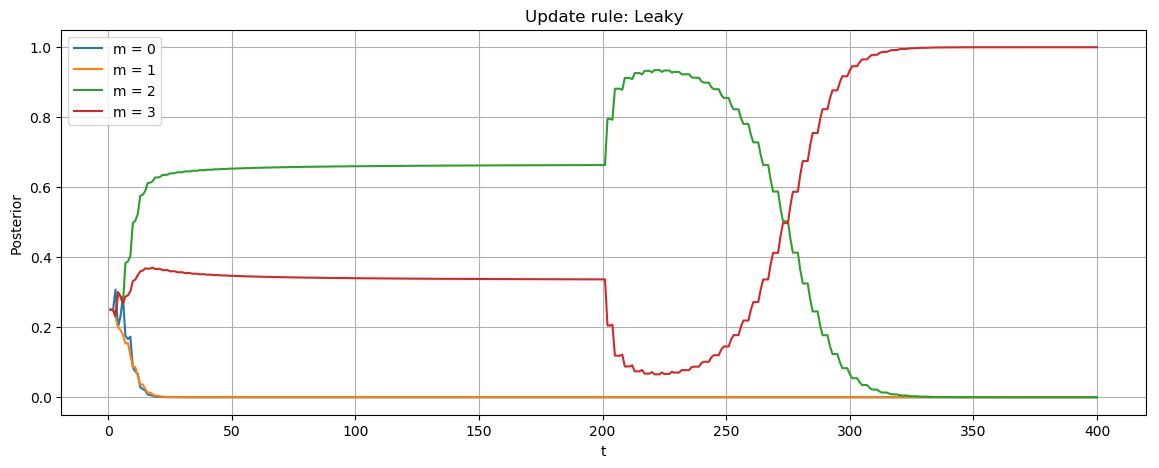

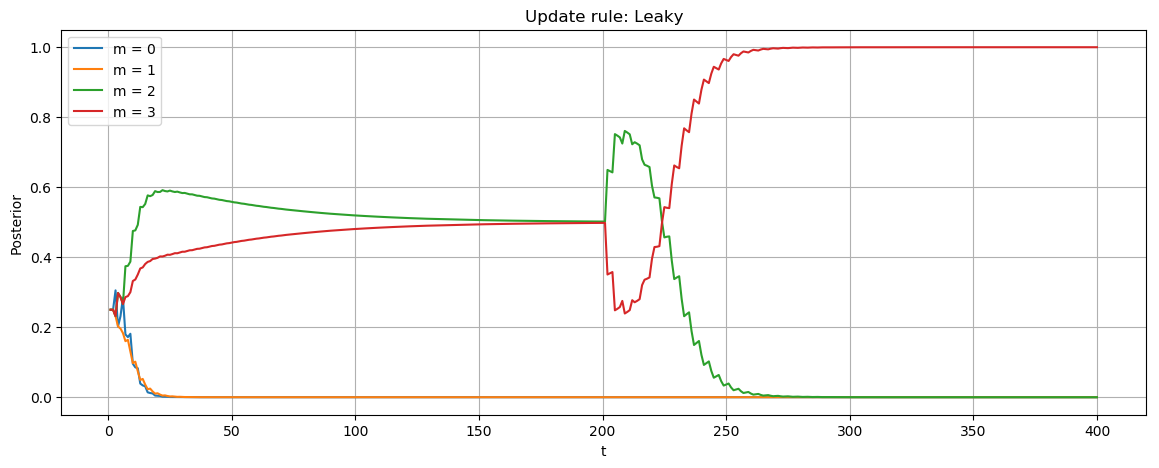

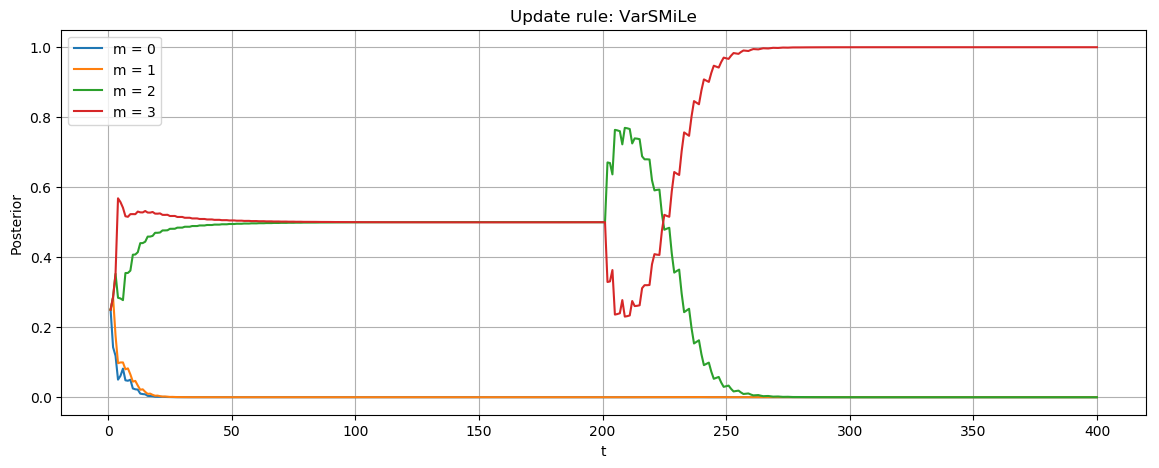

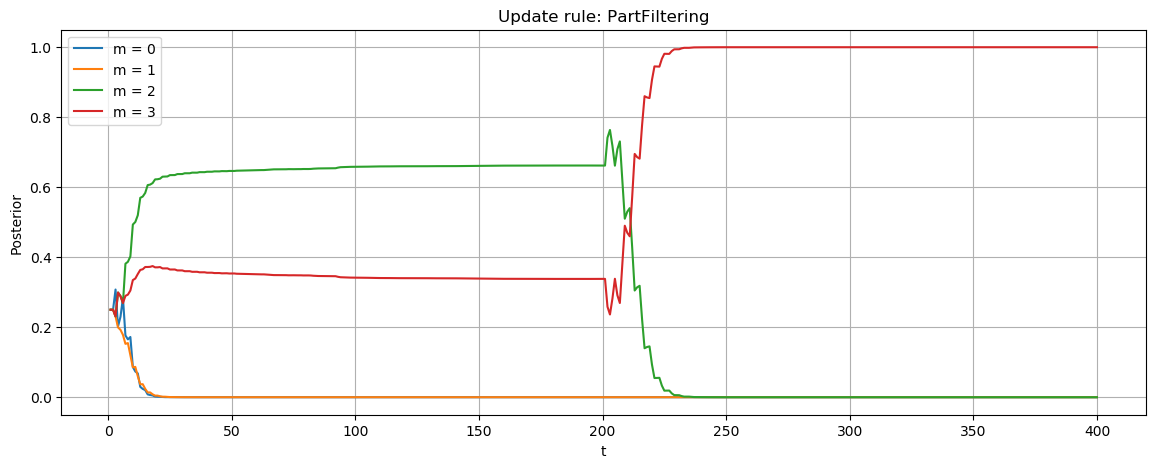

In [103]:
# rules to plot
prior = prior_uniform(3)

rules = [
    Leaky(Inf, prior, updateallcols=true),
    Leaky(40, prior, leakprior=true, updateallcols=true),
    VarSMiLe(0.025, prior, updateallcols=true),
    ParticleFiltering(0.025, 100, 25, prior, updateallcols=true)
]

for rule in rules
    # reset figure
    fig, ax = subplots(figsize=(14,5))
    
    posterior = decodeposterior(seq, rule)

    # plotting params
    params = Dict("rule" => split(rule.str, "(")[1])
    plot_posterior(posterior, params, 1, 400)
    
    # add y lim
    ax = gca()    
    ax.set_ylim([-0.05,1.05])
end
;

In [110]:
# generate sequence
len = 600
seq = Array{Int32,1}(undef, len)

phigh = 2.0/3.0 * ones(300)
plow = 1.0/3.0 * ones(300)
p = vcat(phigh, plow) #, phigh, plow)

for i = 1:len
    seq[i] = rand() > p[i]
end
;

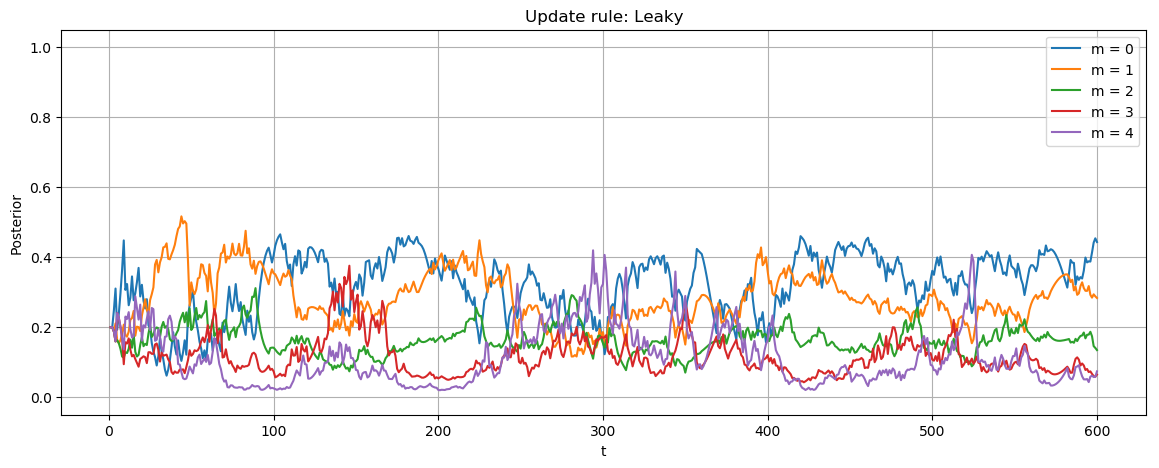

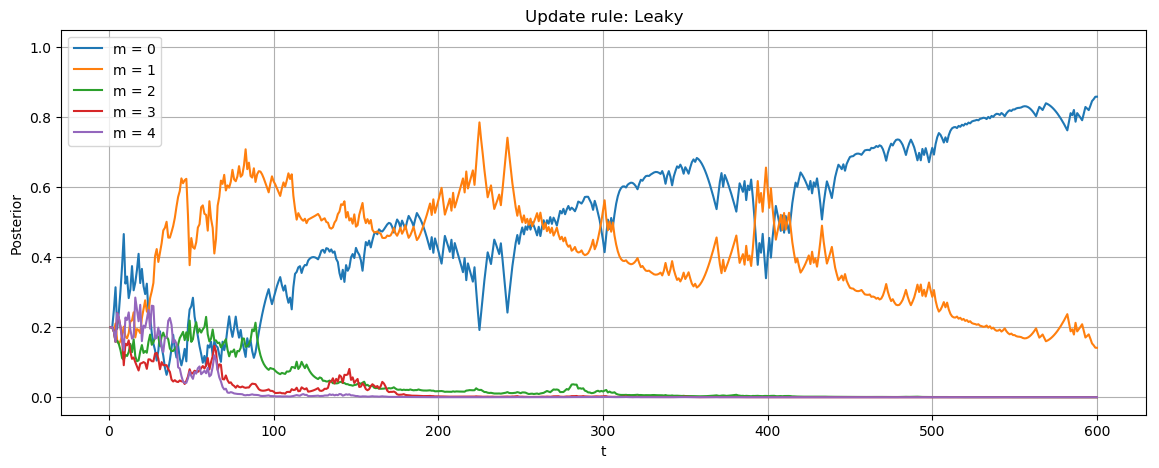

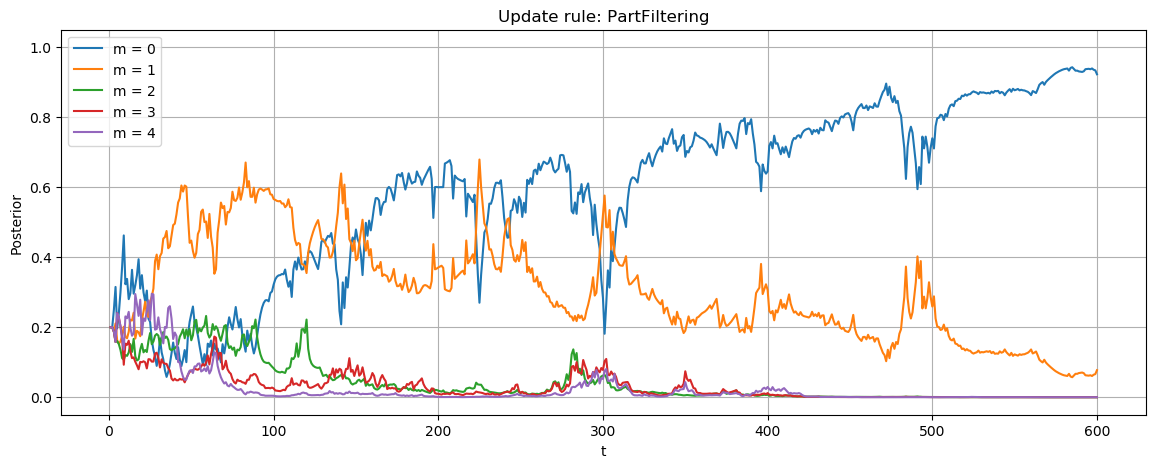

In [112]:
# rules to plot
w = 50
pc = 1 - exp(- 1.0 / w)
mc = pc / (1 - pc) 

Nparticles = 100
Nthrs = Int(Nparticles / 2)

prior = prior_uniform(4)
rules = [
    Leaky(w, prior, leakprior=true, updateallcols=true),
    Leaky(w, prior, leakprior=false, updateallcols=true),
    ParticleFiltering(mc, Nparticles, Nthrs, prior, updateallcols=true)
]


for rule in rules
    # reset figure
    fig, ax = subplots(figsize=(14,5))
    
    posterior = decodeposterior(seq, rule)

    # plotting params
    params = Dict("rule" => split(rule.str, "(")[1])
    plot_posterior(posterior, params, 1, 600)
    
    # add y lim
    ax = gca()    
    ax.set_ylim([-0.05,1.05])
end
;

## Theta

In [6]:
# generate sequence
len = 1200
seq = Array{Int32,1}(undef, len)

phigh = 2.0/3.0 * ones(300)
plow = 1.0/3.0 * ones(300)
p = vcat(phigh, plow, phigh, plow)

for i = 1:len
    seq[i] = rand() > p[i]
end
;

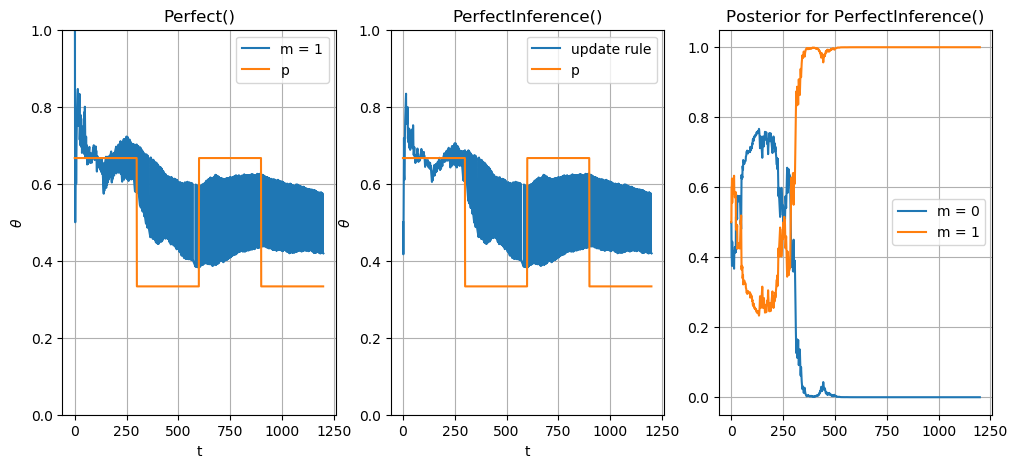

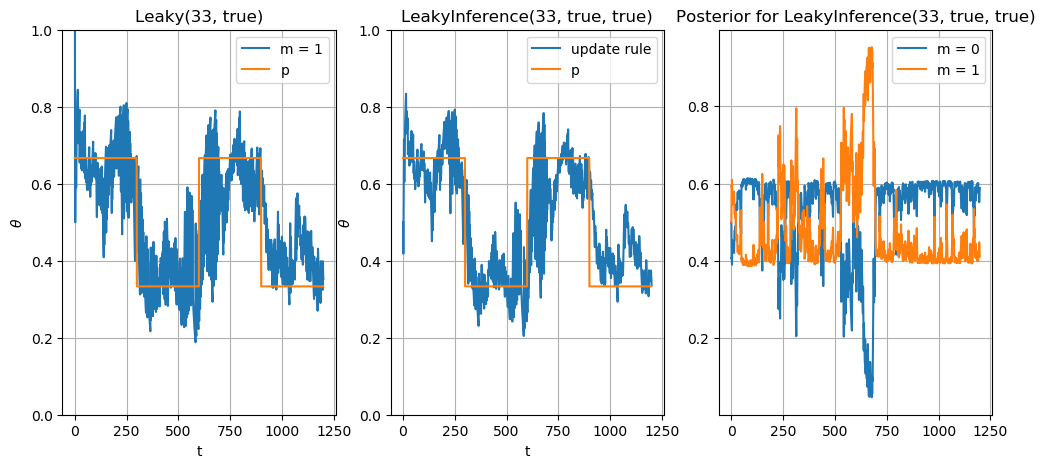

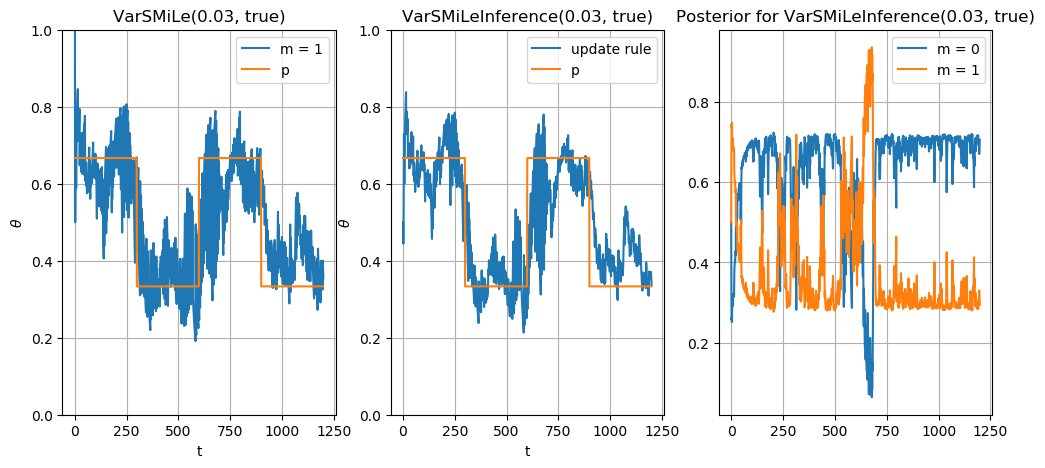

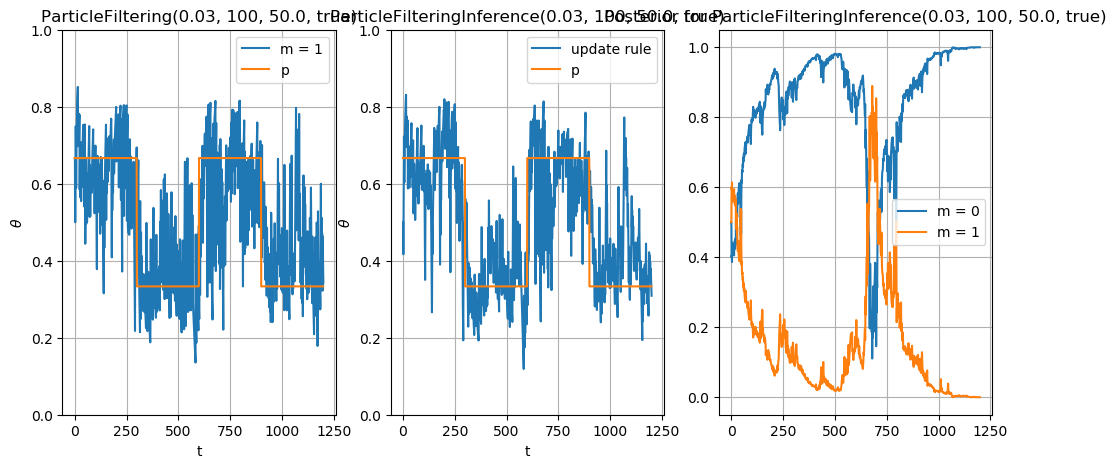

In [8]:
# rules to plot
Nparticles = 100
Nthrs = Nparticles / 2

rules_fix = [
    Perfect(),
    Leaky(33, true),
    VarSMiLe(0.03, true),
    ParticleFiltering(0.03, Nparticles, Nthrs, true)
]
m = 1

rules_inf = [
    LeakyInference(Inf),
    LeakyInference(33, true, true),
    VarSMiLeInference(0.03, true),
    ParticleFilteringInference(0.03, Nparticles, Nthrs, true)
]
prior = prior_uniform(1)

start = 1
stop = 1200

for (rule_fix, rule_inf) in zip(rules_fix, rules_inf)
    # reset figure
    fig, ax = subplots(figsize=(12,5))
    
    # Fixed
    subplot(131)
    sbf_fix, theta_fix = decode_sbftheta(seq, m, ones(2, 2^m), rule_fix)
    theta_fix[start:stop] = theta_fix[start:stop] .* (1 .- seq) + (1 .- theta_fix[start:stop]) .* seq

    # plotting params
    params = Dict("label" => "m = $m", "rule" => rule_fix.str)
    plot_theta(theta_fix, params, start, stop)

    # add p
    plot(p[start:stop], label="p")
    legend()
    
    # add y limits from 0 - 1
    ax = gca()    
    ax.set_ylim([0,1])
    
    
    # Inference
    subplot(132)
    sbf_inf, theta_inf, post_inf = decode_sbfthetaprior_with_inference(seq, rule_inf, prior)
    theta_inf[start:stop] = theta_inf[start:stop] .* (1 .- seq) .+ (1 .- theta_inf[start:stop]) .* seq

    # plotting params
    params = Dict("label" => "update rule", "rule" => rule_inf.str)
    plot_theta(theta_inf, params, start, stop)

    # add p
    plot(p[start:stop], label="p")
    legend()
    
    # add y limits from 0 - 1
    ax = gca()    
    ax.set_ylim([0,1])
    
    subplot(133)
    post = unwrap(post_inf[start:stop])
    for i in 1:size(post,2)
        plot(post[:,i], label="m = $(i-1)")
    end
    grid("on")
    title("Posterior for $(rule_inf.str)")
    legend()
end